In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from datetime import datetime
import statsmodels.formula.api as smf


from utils import concat_dfs, substituir_cod_municipio, criar_dataset_completo

%cd ..


d:\OneDrive\Documentos\Programming\monografia


In [2]:
df_all = criar_dataset_completo()

## Grau de cobertura


taxa de internacoes

-0.0012664688520048193
-0.0021359473482623933
-0.0022623649882050094
-0.0016540522074830087
-0.003573192647021297
-0.00016281550371539076
-0.0039573754648008705
-0.0030853813854548814
-0.0033866223874308276
-0.001351439390055222


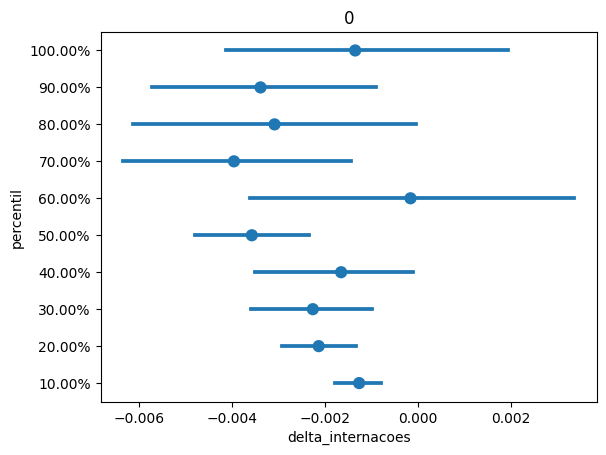

-0.0012400082543338677
-0.00269231595517031
-0.0028112064064351435
-0.0014961568640586712
-0.00319202269304865
-0.0035077995060451925
-0.0030052139117470907
-0.002492128884334161
-0.00485980187740794
-0.0016493159624799223


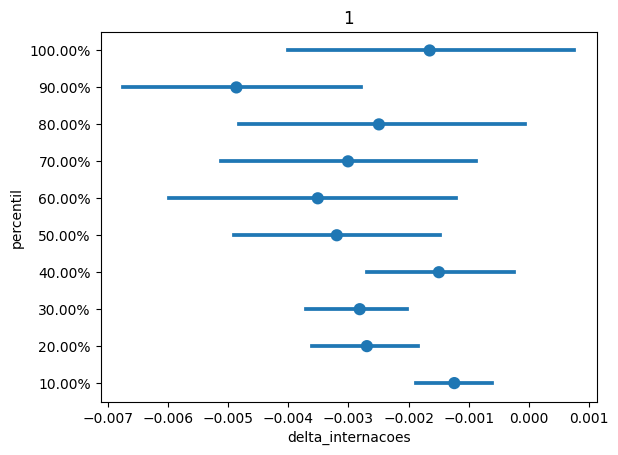

-0.001276557581455005
-0.0025156345611278275
-0.002646216681425573
-0.002191321022393708
-0.0023282289212387787
-0.003900396358552001
-0.0024857678894960253
-0.0006808885087303332
-0.0026614926907678627
-0.0011484615795401415


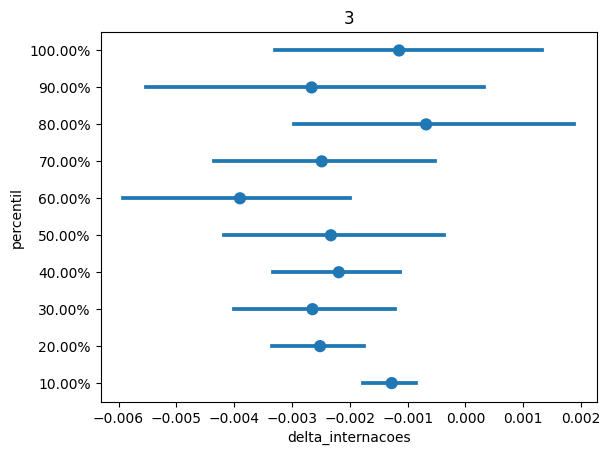

-0.0016015933660319735
-0.0030922817348443266
-0.002931489288783948
-0.0032561554445797716
-0.0035903818838451586
-0.004696434702092805
-0.002692620463206539
-0.003641677199777083
-0.0025374885488555054
-0.00247561254369175


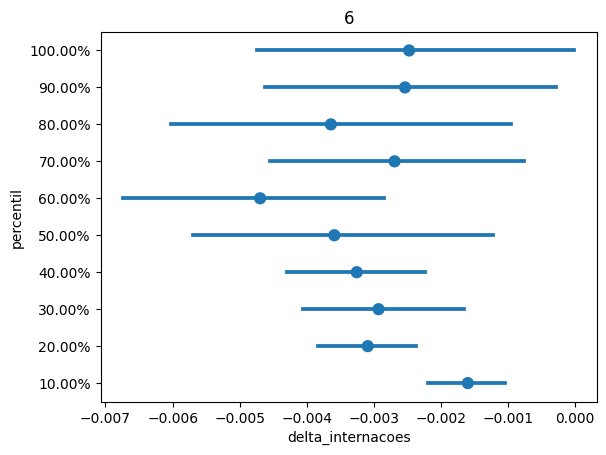

-0.0013812380398611334
-0.002517855048159593
-0.002968614280388732
-0.003933906046564044
-0.004647924290190555
-0.004932980936463886
-0.003350292927120007
-0.004378279425220951
-0.003932567959122675
-0.002818229984852795


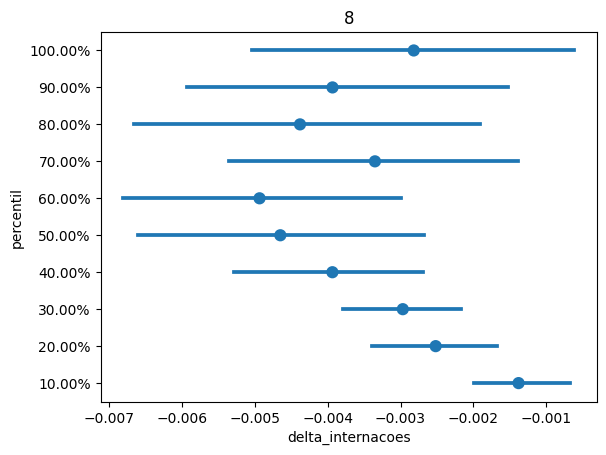

In [85]:
for n_meses in [0, 1, 3, 6, 8]:

    delta_meses = relativedelta(months=n_meses)

    mes_corte_1 = "2020-03-01"
    mes_corte_2 = "2020-04-01"

    start_date = pd.to_datetime(mes_corte_1) - delta_meses
    end_date = pd.to_datetime(mes_corte_2) + delta_meses

    # print(start_date)
    # print(end_date)

    df_antes = df_all[
        (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
    ]
    df_depois = df_all[
        (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
    ]

    colunas_relevantes = ["municipio_ibge", "cobertura_ae", "taxa_internacoes"]

    df_antes_mean = (
        df_antes.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )
    df_depois_mean = (
        df_depois.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )

    df_antes_depois = pd.merge(
        df_antes_mean, df_depois_mean, on=["municipio_ibge"]
    )
    df_antes_depois["variacao"] = df_antes_depois["cobertura_ae_y"] - df_antes_depois["cobertura_ae_x"]

    divisao = 10
    df_divisions = np.array_split(
        df_antes_depois.sort_values("variacao"), divisao
    )
    for i, dfs_division in enumerate(df_divisions):
        indices = dfs_division.index
        df_antes_depois.loc[indices, "percentil"] = (i / divisao) + (
            1 / divisao
        )

    df_antes_depois["delta_internacoes"] = (
        df_antes_depois["taxa_internacoes_y"] - df_antes_depois["taxa_internacoes_x"]
    )

    for i, df_percentil in enumerate(df_divisions):
        print(
            df_percentil["taxa_internacoes_y"].mean()
            - df_percentil["taxa_internacoes_x"].mean()
        )
        pass

    ax = sns.pointplot(
        data=df_antes_depois,
        x="delta_internacoes",
        y="percentil",
        join=False,
        orient="h",
        order=-np.sort(-df_antes_depois["percentil"].unique()),
    )
    y_value = [
        "{:,.2f}".format(x * 100) + "%"
        for x in -np.sort(-df_antes_depois["percentil"].unique())
    ]
    ax.set_yticklabels(y_value)
    plt.title(n_meses)
    plt.show()


In [89]:
for n_meses in [0, 1, 3, 6, 8]:

    delta_meses = relativedelta(months=n_meses)

    mes_corte_1 = "2020-03-01"
    mes_corte_2 = "2020-04-01"

    start_date = pd.to_datetime(mes_corte_1) - delta_meses
    end_date = pd.to_datetime(mes_corte_2) + delta_meses

    # print(start_date)
    # print(end_date)

    df_antes = df_all[
        (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
    ]
    df_depois = df_all[
        (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
    ]

    df_antes['depois'] = 0
    df_depois['depois'] = 1

    colunas_relevantes = ["municipio_ibge", "cobertura_ae", "taxa_internacoes", "depois"]

    df_antes_mean = (
        df_antes.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )
    df_depois_mean = (
        df_depois.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )

    divisao = 10

    maiores = np.array_split(df_depois_mean.sort_values('cobertura_ae')['municipio_ibge'], divisao)[-1].values
    menores = np.array_split(df_depois_mean.sort_values('cobertura_ae')['municipio_ibge'], divisao)[0].values

    df_antes_depois = pd.concat([df_antes_mean, df_depois_mean], ignore_index=True) 

    df_antes_depois.loc[df_antes_depois['municipio_ibge'].isin(maiores), 'tratamento'] = 1
    df_antes_depois.loc[df_antes_depois['municipio_ibge'].isin(menores), 'tratamento'] = 0

    print(smf.ols('taxa_internacoes ~ depois*tratamento', data=df_antes_depois[(df_antes_depois['municipio_ibge'].isin(maiores)) |(df_antes_depois['municipio_ibge'].isin(menores))]).fit().summary().tables[1])



C:\Users\diego\AppData\Local\Temp\ipykernel_1672\1927650286.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_antes['depois'] = 0
C:\Users\diego\AppData\Local\Temp\ipykernel_1672\1927650286.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_depois['depois'] = 1


                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0043      0.002      2.831      0.005       0.001       0.007
depois               -0.0013      0.002     -0.591      0.555      -0.005       0.003
tratamento            0.0098      0.002      4.578      0.000       0.006       0.014
depois:tratamento -8.497e-05      0.003     -0.028      0.978      -0.006       0.006


C:\Users\diego\AppData\Local\Temp\ipykernel_1672\1927650286.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_antes['depois'] = 0
C:\Users\diego\AppData\Local\Temp\ipykernel_1672\1927650286.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_depois['depois'] = 1


                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0044      0.001      3.053      0.002       0.002       0.007
depois               -0.0012      0.002     -0.604      0.546      -0.005       0.003
tratamento            0.0106      0.002      5.183      0.000       0.007       0.015
depois:tratamento    -0.0004      0.003     -0.141      0.888      -0.006       0.005


C:\Users\diego\AppData\Local\Temp\ipykernel_1672\1927650286.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_antes['depois'] = 0
C:\Users\diego\AppData\Local\Temp\ipykernel_1672\1927650286.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_depois['depois'] = 1


                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0045      0.001      3.198      0.001       0.002       0.007
depois               -0.0013      0.002     -0.646      0.519      -0.005       0.003
tratamento            0.0101      0.002      5.122      0.000       0.006       0.014
depois:tratamento     0.0001      0.003      0.046      0.963      -0.005       0.006


C:\Users\diego\AppData\Local\Temp\ipykernel_1672\1927650286.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_antes['depois'] = 0
C:\Users\diego\AppData\Local\Temp\ipykernel_1672\1927650286.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_depois['depois'] = 1


                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0048      0.001      3.433      0.001       0.002       0.008
depois               -0.0016      0.002     -0.808      0.419      -0.005       0.002
tratamento            0.0116      0.002      5.874      0.000       0.008       0.016
depois:tratamento    -0.0009      0.003     -0.312      0.755      -0.006       0.005
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0053      0.001      3.855      0.000       0.003       0.008
depois               -0.0014      0.002     -0.706      0.480      -0.005       0.002
tratamento            0.0110      0.002      5.598      0.000       0.007       0.015
depois:tratamento    -0.0014      0.003     -0.519    

C:\Users\diego\AppData\Local\Temp\ipykernel_1672\1927650286.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_antes['depois'] = 0
C:\Users\diego\AppData\Local\Temp\ipykernel_1672\1927650286.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_depois['depois'] = 1


In [77]:
maiores.values

array([3305307., 3116704., 5213905., ..., 5204953., 2919959., 2413607.])

taxa internacoes jovens

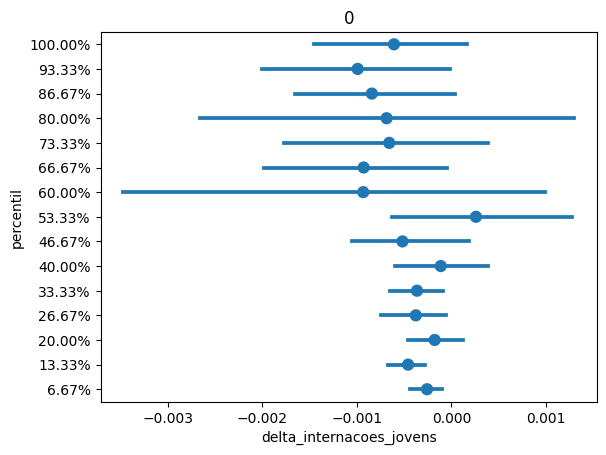

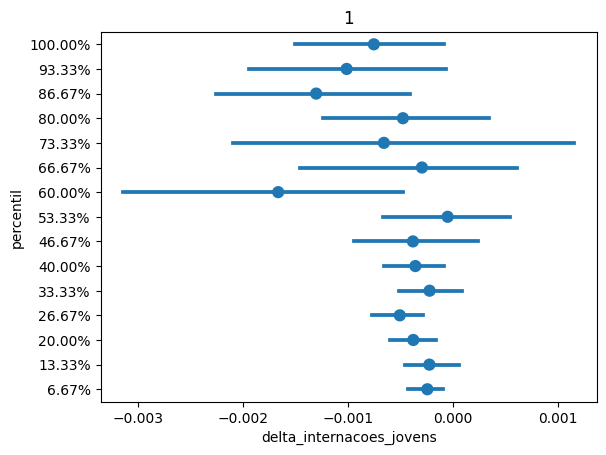

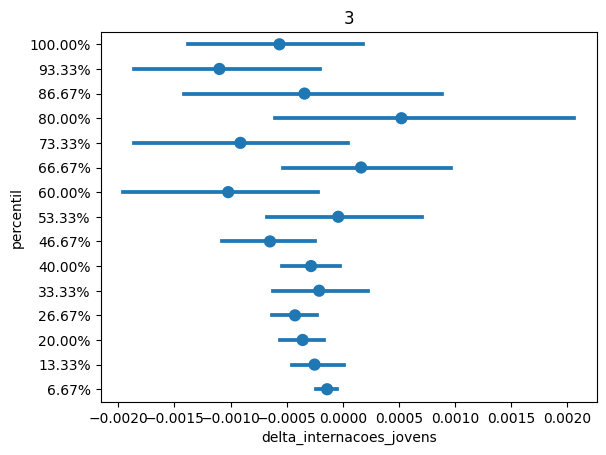

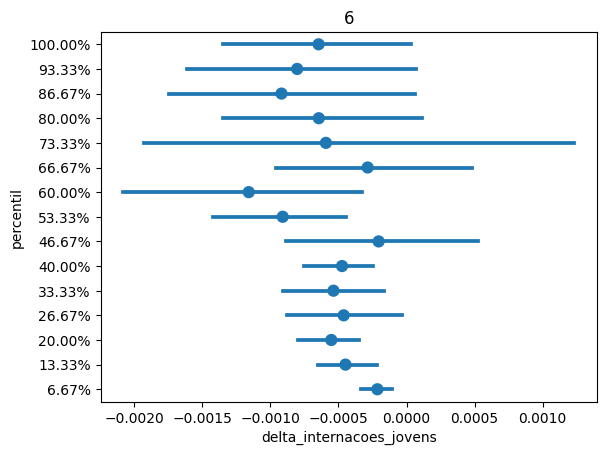

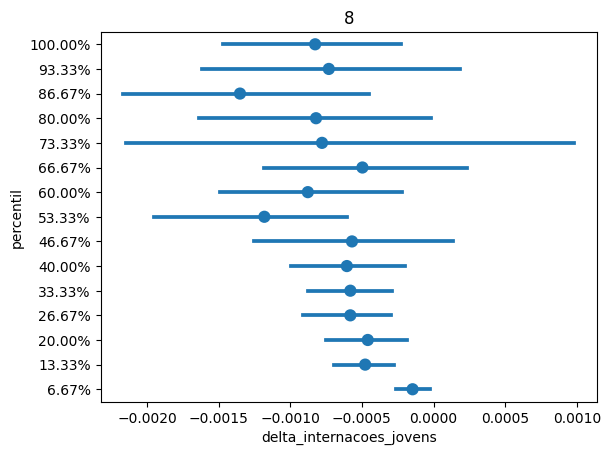

In [4]:
for n_meses in [0, 1, 3, 6, 8]:

    delta_meses = relativedelta(months=n_meses)

    mes_corte_1 = "2020-03-01"
    mes_corte_2 = "2020-04-01"

    start_date = pd.to_datetime(mes_corte_1) - delta_meses
    end_date = pd.to_datetime(mes_corte_2) + delta_meses

    # print(start_date)
    # print(end_date)

    df_antes = df_all[
        (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
    ]
    df_depois = df_all[
        (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
    ]

    colunas_relevantes = ["municipio_ibge", "cobertura_ae", "taxa_internacoes_jovens"]

    df_antes_mean = (
        df_antes.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )
    df_depois_mean = (
        df_depois.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )

    df_antes_depois = pd.merge(
        df_antes_mean, df_depois_mean, on=["municipio_ibge"]
    )
    df_antes_depois["variacao"] = df_antes_depois["cobertura_ae_y"] - 0

    divisao = 15
    df_divisions = np.array_split(
        df_antes_depois.sort_values("variacao"), divisao
    )
    for i, dfs_division in enumerate(df_divisions):
        indices = dfs_division.index
        df_antes_depois.loc[indices, "percentil"] = (i / divisao) + (
            1 / divisao
        )

    df_antes_depois["delta_internacoes_jovens"] = (
        df_antes_depois["taxa_internacoes_jovens_y"] - df_antes_depois["taxa_internacoes_jovens_x"]
    )

    # for i, df_percentil in enumerate(df_divisions):
    #     print(
    #         df_percentil["taxa_internacoes_jovens_y"].mean()
    #         - df_percentil["taxa_internacoes_jovens_x"].mean()
    #     )
    #     pass

    ax = sns.pointplot(
        data=df_antes_depois,
        x="delta_internacoes_jovens",
        y="percentil",
        join=False,
        orient="h",
        order=-np.sort(-df_antes_depois["percentil"].unique()),
    )
    y_value = [
        "{:,.2f}".format(x * 100) + "%"
        for x in -np.sort(-df_antes_depois["percentil"].unique())
    ]
    ax.set_yticklabels(y_value)
    plt.title(n_meses)
    plt.show()


internacoes por 100

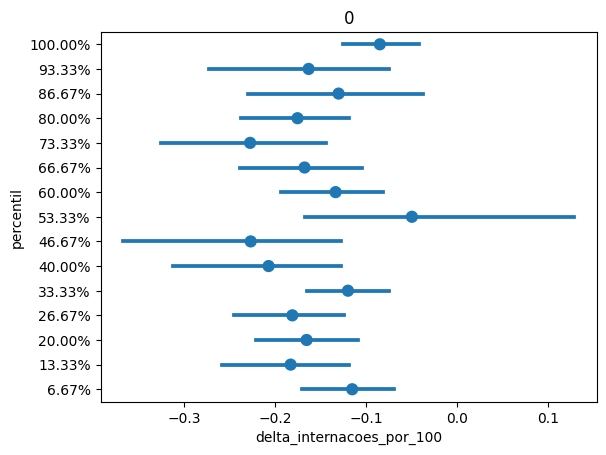

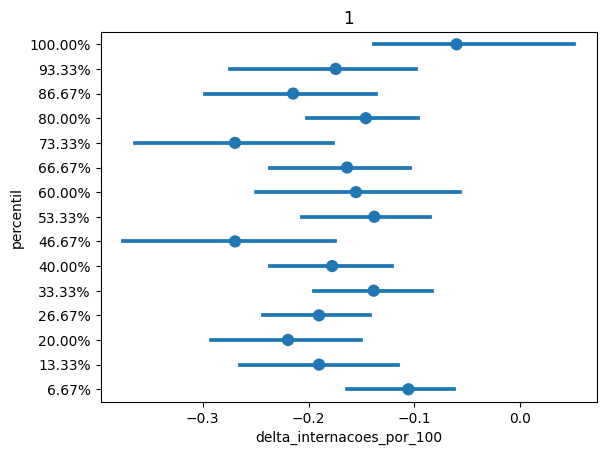

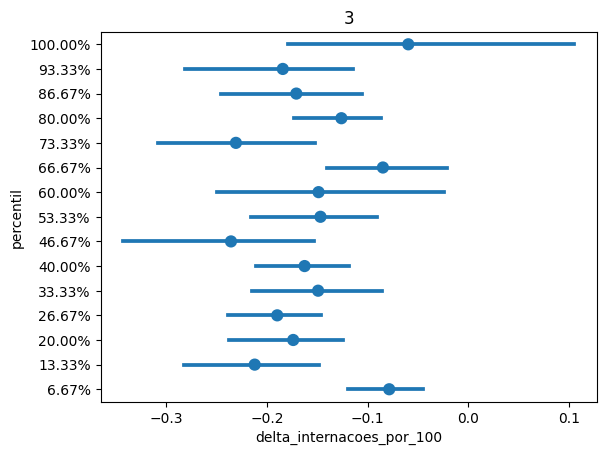

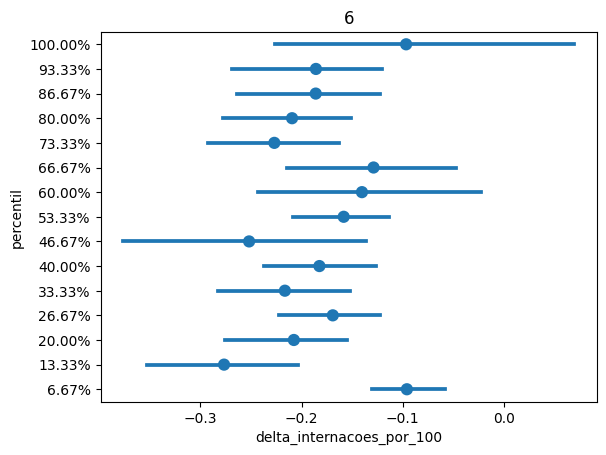

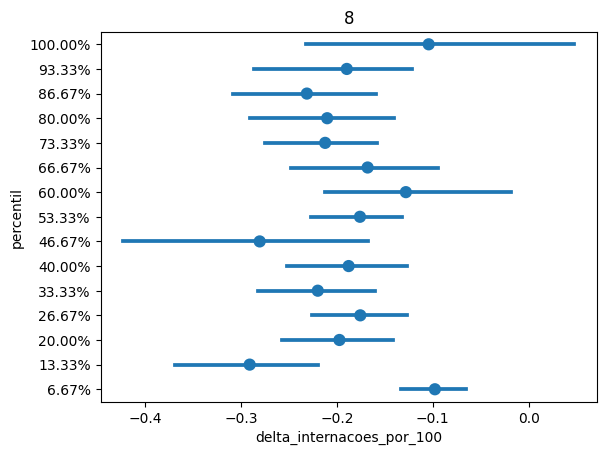

In [5]:
for n_meses in [0, 1, 3, 6, 8]:

    delta_meses = relativedelta(months=n_meses)

    mes_corte_1 = "2020-03-01"
    mes_corte_2 = "2020-04-01"

    start_date = pd.to_datetime(mes_corte_1) - delta_meses
    end_date = pd.to_datetime(mes_corte_2) + delta_meses

    # print(start_date)
    # print(end_date)

    df_antes = df_all[
        (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
    ]
    df_depois = df_all[
        (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
    ]

    colunas_relevantes = ["municipio_ibge", "cobertura_ae", "internacoes_por_100"]

    df_antes_mean = (
        df_antes.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )
    df_depois_mean = (
        df_depois.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )

    df_antes_depois = pd.merge(
        df_antes_mean, df_depois_mean, on=["municipio_ibge"]
    )
    df_antes_depois["variacao"] = df_antes_depois["cobertura_ae_y"] - 0

    divisao = 15
    df_divisions = np.array_split(
        df_antes_depois.sort_values("variacao"), divisao
    )
    for i, dfs_division in enumerate(df_divisions):
        indices = dfs_division.index
        df_antes_depois.loc[indices, "percentil"] = (i / divisao) + (
            1 / divisao
        )

    df_antes_depois["delta_internacoes_por_100"] = (
        df_antes_depois["internacoes_por_100_y"] - df_antes_depois["internacoes_por_100_x"]
    )

    # for i, df_percentil in enumerate(df_divisions):
    #     print(
    #         df_percentil["internacoes_por_100_y"].mean()
    #         - df_percentil["internacoes_por_100_x"].mean()
    #     )
    #     pass

    ax = sns.pointplot(
        data=df_antes_depois,
        x="delta_internacoes_por_100",
        y="percentil",
        join=False,
        orient="h",
        order=-np.sort(-df_antes_depois["percentil"].unique()),
    )
    y_value = [
        "{:,.2f}".format(x * 100) + "%"
        for x in -np.sort(-df_antes_depois["percentil"].unique())
    ]
    ax.set_yticklabels(y_value)
    plt.title(n_meses)
    plt.show()


internacoes por 100

2020-03-01 00:00:00
2020-04-01 00:00:00
-0.02296083171874995
-0.03850894065002539
-0.027726036824999287
-0.03401465365668685
-0.02292397634178435
-0.029708869983178794
-0.046407108305265815
-0.010110705958856409
-0.038648559077354545
-0.04359107486682243
-0.05953820930493409
-0.04948302188331385
-0.042243790524213995
-0.043683042890163004
-0.03419960294563678


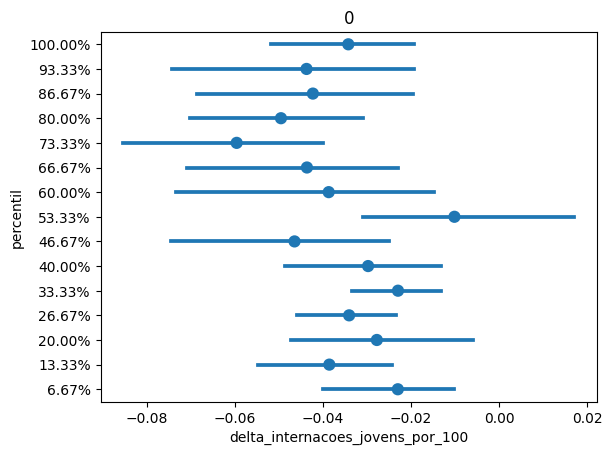

2020-02-01 00:00:00
2020-05-01 00:00:00
-0.021053199113866182
-0.023421236682588137
-0.03615803022306978
-0.031163671497040794
-0.025797127739955822
-0.027936010264085494
-0.03608849840779152
-0.019482520863969108
-0.04892661462993135
-0.038679885214238485
-0.06945127335173817
-0.038724911618137264
-0.0574567297709615
-0.04729002804442413
-0.03463469229235504


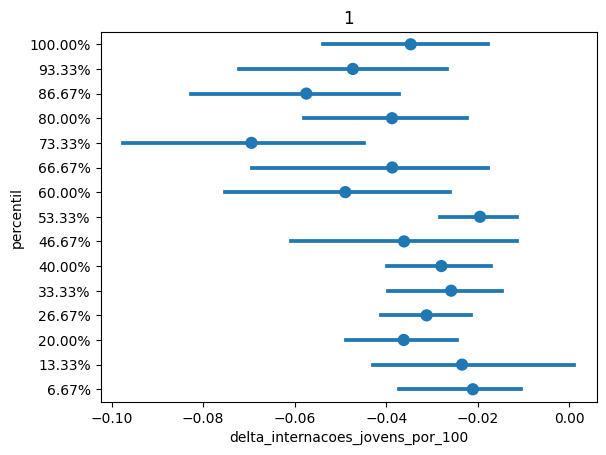

2019-12-01 00:00:00
2020-07-01 00:00:00
-0.011349490955602545
-0.0247987492786807
-0.02678882722450296
-0.02924700325617962
-0.023068078348606573
-0.02590215391541586
-0.03835749637440404
-0.018650472257307503
-0.03820340942356494
-0.01750390681775478
-0.0599092964125256
-0.032090882702767574
-0.04677965208112082
-0.05338479486938503
-0.03779179359965498


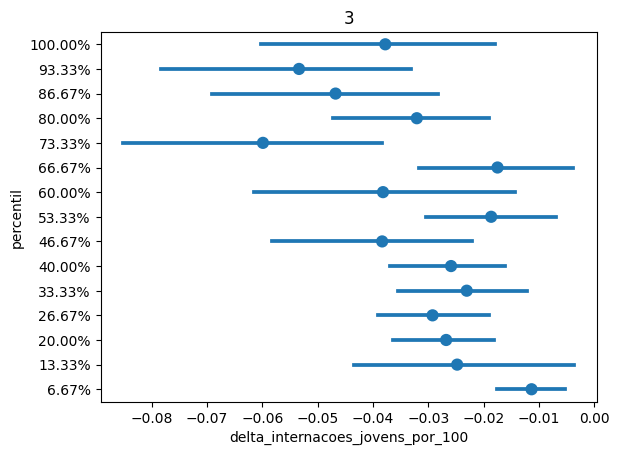

2019-09-01 00:00:00
2020-10-01 00:00:00
-0.014799219925156468
-0.045488782093083366
-0.03552926879326504
-0.028264899788873345
-0.034034133001169746
-0.030304331229063855
-0.0283033890406785
-0.033279247091365385
-0.03430262889924007
-0.028429909177243542
-0.062378525456990574
-0.04902150849768781
-0.05770657463925946
-0.05092428744925513
-0.04347693049559306


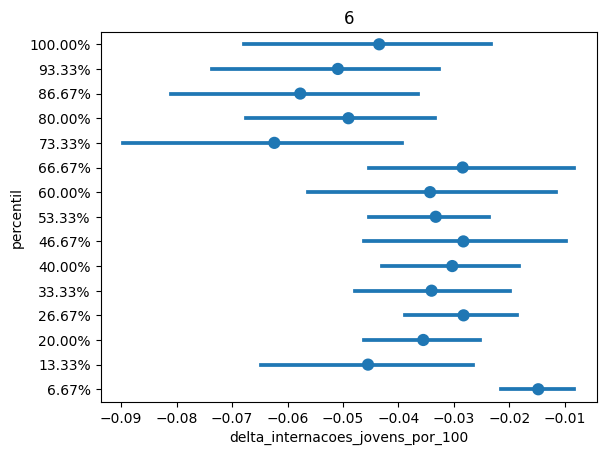

2019-07-01 00:00:00
2020-12-01 00:00:00
-0.014439373554686746
-0.049401627549374966
-0.031977836493339615
-0.02861484162489729
-0.035243277810490234
-0.03460915657566356
-0.03634059960918069
-0.03537277860876298
-0.028675477174972805
-0.03414055515256442
-0.05964612994855224
-0.05206263547462678
-0.06496954227558868
-0.050312473034870714
-0.04520982161163412


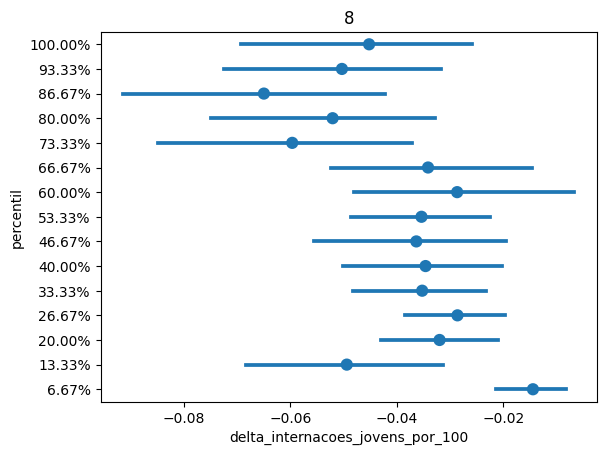

In [6]:
for n_meses in [0, 1, 3, 6, 8]:

    delta_meses = relativedelta(months=n_meses)

    mes_corte_1 = "2020-03-01"
    mes_corte_2 = "2020-04-01"

    start_date = pd.to_datetime(mes_corte_1) - delta_meses
    end_date = pd.to_datetime(mes_corte_2) + delta_meses

    # print(start_date)
    # print(end_date)

    df_antes = df_all[
        (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
    ]
    df_depois = df_all[
        (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
    ]

    colunas_relevantes = ["municipio_ibge", "cobertura_ae", "internacoes_jovens_por_100"]

    df_antes_mean = (
        df_antes.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )
    df_depois_mean = (
        df_depois.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )

    df_antes_depois = pd.merge(
        df_antes_mean, df_depois_mean, on=["municipio_ibge"]
    )
    df_antes_depois["variacao"] = df_antes_depois["cobertura_ae_y"] - 0

    divisao = 15
    df_divisions = np.array_split(
        df_antes_depois.sort_values("variacao"), divisao
    )
    for i, dfs_division in enumerate(df_divisions):
        indices = dfs_division.index
        df_antes_depois.loc[indices, "percentil"] = (i / divisao) + (
            1 / divisao
        )

    df_antes_depois["delta_internacoes_jovens_por_100"] = (
        df_antes_depois["internacoes_jovens_por_100_y"] - df_antes_depois["internacoes_jovens_por_100_x"]
    )

    # for i, df_percentil in enumerate(df_divisions):
    #     print(
    #         df_percentil["internacoes_jovens_por_100_y"].mean()
    #         - df_percentil["internacoes_jovens_por_100_x"].mean()
    #     )
    #     pass

    ax = sns.pointplot(
        data=df_antes_depois,
        x="delta_internacoes_jovens_por_100",
        y="percentil",
        join=False,
        orient="h",
        order=-np.sort(-df_antes_depois["percentil"].unique()),
    )
    y_value = [
        "{:,.2f}".format(x * 100) + "%"
        for x in -np.sort(-df_antes_depois["percentil"].unique())
    ]
    ax.set_yticklabels(y_value)
    plt.title(n_meses)
    plt.show()
